In [1]:
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import os
from Helpers import plot_utility
from P2_PostProcess.VirtualReality.plotting import get_vmin_vmax, min_max_normalize
from P2_PostProcess.VirtualReality.spatial_information import calculate_spatial_information

In [5]:
def get_data(vr_session_base_names, of_session_base_names, curate=True):
    project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
    
    master_data = pd.DataFrame()
    for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
        spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")
        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])

        position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
        processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
        position_data = pd.read_csv(position_path)
        processed_position_data = pd.read_pickle(processed_position_path)
        spike_data = calculate_spatial_information(spike_data, position_data, track_length=200)
        spike_data = spike_data.sort_values(by=["spatial_information_score_Isec"], ascending=False)

        print(f"for {mouse} {day}, there are {len(spike_data)}")
        if curate:
            spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                                    (spike_data["mean_firing_rate_x"] > 0.5) & 
                                    (spike_data["rp_contamination_x"] < 0.9) &
                                    (spike_data["sd_ratio_x"] > 1)]
            print(f"after curation, there are {len(spike_data)}")
        master_data = pd.concat([master_data, spike_data],ignore_index=True)
    return master_data

In [6]:
def plot_rate_maps(spike_data):
    if "firing_times_vr" in list(spike_data):
        fr_col = "firing_times_vr"
    else:
        fr_col = "firing_times"
        
    rate_maps = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        firing_times_cluster = spike_data[fr_col].iloc[cluster_index]

        if len(firing_times_cluster)>1:
            cluster_firing_maps = np.array(spike_data['fr_binned_in_space_smoothed'].iloc[cluster_index])
            cluster_firing_maps[np.isnan(cluster_firing_maps)] = 0
            cluster_firing_maps[np.isinf(cluster_firing_maps)] = 0
            percentile_99th_display = np.nanpercentile(cluster_firing_maps, 95);
            cluster_firing_maps = min_max_normalize(cluster_firing_maps)
            percentile_99th = np.nanpercentile(cluster_firing_maps, 95); 
            cluster_firing_maps = np.clip(cluster_firing_maps, a_min=0, a_max=percentile_99th)
            vmin, vmax = get_vmin_vmax(cluster_firing_maps)
            rate_maps.append(cluster_firing_maps)

    cmap = plt.cm.get_cmap("viridis")
    nrows = int(np.ceil(np.sqrt(len(spike_data))))
    ncols = nrows; i=0; j=0;
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20), squeeze=False)
    for m, rate_map in enumerate(rate_maps):
        vmin, vmax = get_vmin_vmax(rate_map)
        locations = np.arange(0, len(rate_map[0]))
        ordered = np.arange(0, len(rate_map), 1)
        X, Y = np.meshgrid(locations, ordered)
        ax[j, i].pcolormesh(X, Y, rate_map, cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)
        #ax[j, i].text(0,0, spike_data["cluster_id"].iloc[m],color="white", fontsize=15)
        i+=1
        if i==ncols:
            i=0; j+=1
    for j in range(nrows):
        for i in range(ncols):
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
    plt.subplots_adjust(hspace=.1, wspace=.1, bottom=None, left=None, right=None, top=None)
    plt.show()

def plot_average_rate_maps(spike_data):
    if "firing_times_vr" in list(spike_data):
        fr_col = "firing_times_vr"
    else:
        fr_col = "firing_times"
        
    rate_maps = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        firing_times_cluster = spike_data[fr_col].iloc[cluster_index]

        if len(firing_times_cluster)>1:
            cluster_firing_maps = np.array(spike_data['fr_binned_in_space_smoothed'].iloc[cluster_index])
            cluster_firing_maps[np.isnan(cluster_firing_maps)] = 0
            cluster_firing_maps[np.isinf(cluster_firing_maps)] = 0
            percentile_99th_display = np.nanpercentile(cluster_firing_maps, 95);
            cluster_firing_maps = min_max_normalize(cluster_firing_maps)
            percentile_99th = np.nanpercentile(cluster_firing_maps, 95); 
            cluster_firing_maps = np.clip(cluster_firing_maps, a_min=0, a_max=percentile_99th)
            vmin, vmax = get_vmin_vmax(cluster_firing_maps)
            rate_maps.append(cluster_firing_maps)

    nrows = int(np.ceil(np.sqrt(len(spike_data))))
    ncols = nrows; i=0; j=0;
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20), squeeze=False)
    for m, rate_map in enumerate(rate_maps):
        locations = np.arange(0, len(rate_map[0]))
        ax[j, i].fill_between(locations, np.nanmean(rate_map, axis=0) - stats.sem(rate_map, axis=0,nan_policy="omit"),
                                    np.nanmean(rate_map, axis=0) + stats.sem(rate_map, axis=0,nan_policy="omit"), color="black", alpha=0.2)
        ax[j, i].plot(locations, np.nanmean(rate_map, axis=0), color="black", linewidth=1)
        ax[j, i].set_xlim([0, len(rate_map[0])])
        max_fr = max(np.nanmean(rate_map, axis=0)+stats.sem(rate_map, axis=0))
        max_fr = max_fr+(0.1*(max_fr))
        ax[j, i].set_ylim([0, max_fr])
        ax[j, i].set_yticks([0, np.round(ax[j, i].get_ylim()[1], 1)])
        ax[j, i].set_ylim(bottom=0)
        plot_utility.style_track_plot(ax[j, i], len(rate_map[0]), alpha=0.15)
        i+=1
        if i==ncols:
            i=0; j+=1
    for j in range(nrows):
        for i in range(ncols):
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
    plt.subplots_adjust(hspace=.1, wspace=.1, bottom=None, left=None, right=None, top=None)
    plt.show()

def plot_of_rate_maps(spike_data):

    rate_maps = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        cluster_df = spike_data[(spike_data.cluster_id == cluster_id)] # dataframe for that cluster
        firing_rate_map_original = cluster_df['firing_maps'].iloc[0]
        occupancy_map = cluster_df['occupancy_maps'].iloc[0]
        firing_rate_map_original[occupancy_map==0] = np.nan
        firing_rate_map = np.rot90(firing_rate_map_original)
        rate_maps.append(firing_rate_map)
 
    nrows = int(np.ceil(np.sqrt(len(spike_data))))
    ncols = nrows; i=0; j=0; 
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20), squeeze=False)
    cmap = plt.cm.get_cmap("jet")
    cmap.set_bad("white")
    for rate_map in rate_maps:
        ax[j, i].imshow(rate_map, cmap=cmap, interpolation='nearest')
        i+=1
        if i==ncols:
            i=0; j+=1
    for j in range(nrows):
        for i in range(ncols):
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
    plt.show()

#####  I'm first going to look at the data across 4 sessions that sample all locations in the brain and plot the curation metrics for these cells

In [7]:
spike_data = get_data(vr_session_base_names = ["M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"],
                      of_session_base_names = ["M20_D23_2024-05-25_14-10-43_OF1",
                      "M20_D24_2024-05-26_14-17-55_OF1", 
                      "M20_D25_2024-05-27_13-57-19_OF1",
                      "M20_D26_2024-05-28_14-31-11_OF1"], curate=False)

for M20 D23, there are 272
for M20 D24, there are 235
for M20 D25, there are 232
for M20 D26, there are 224


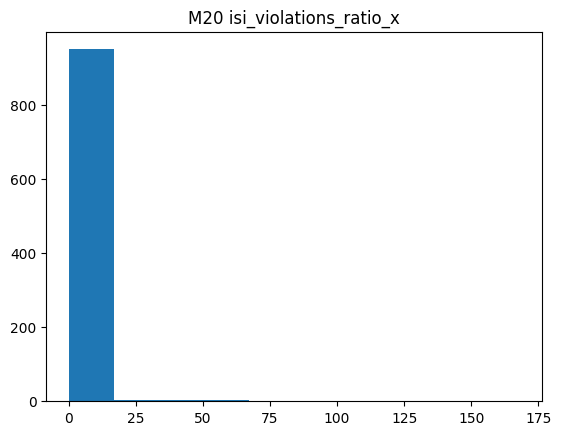

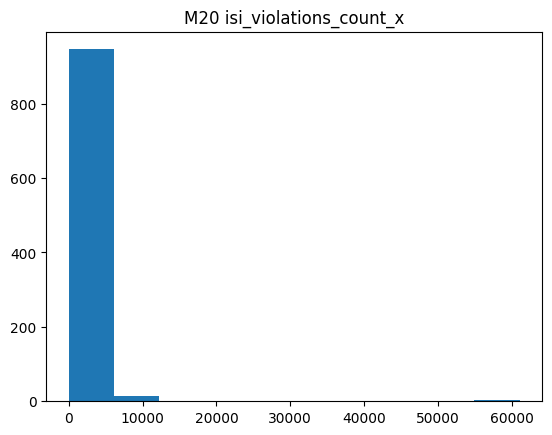

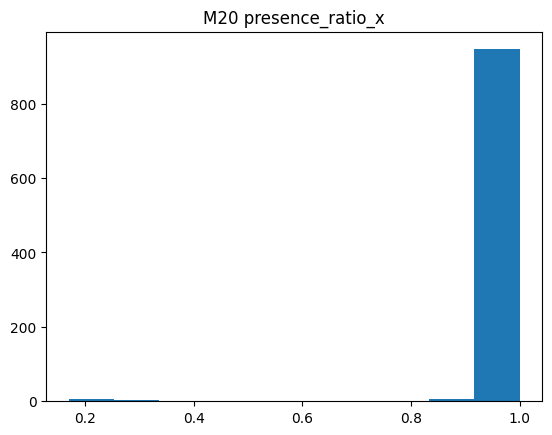

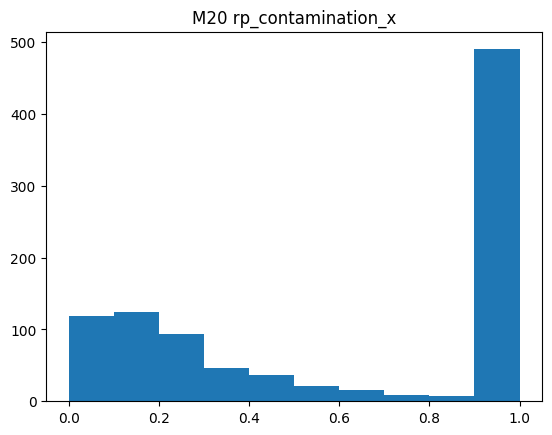

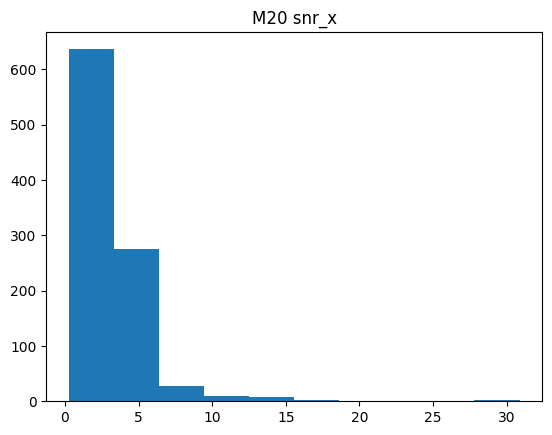

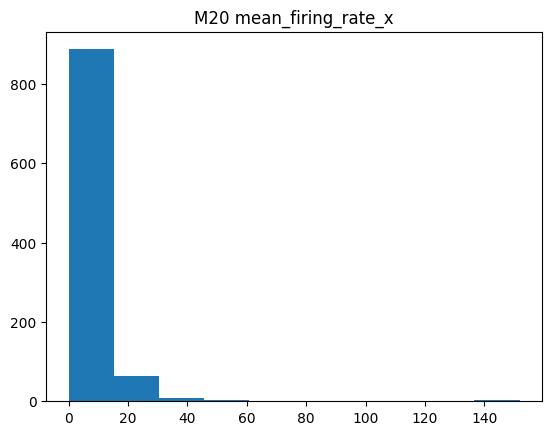

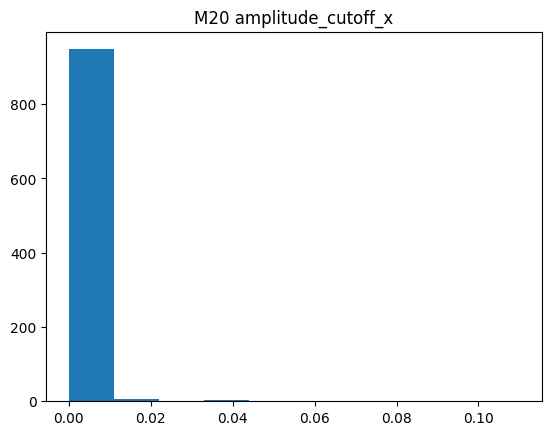

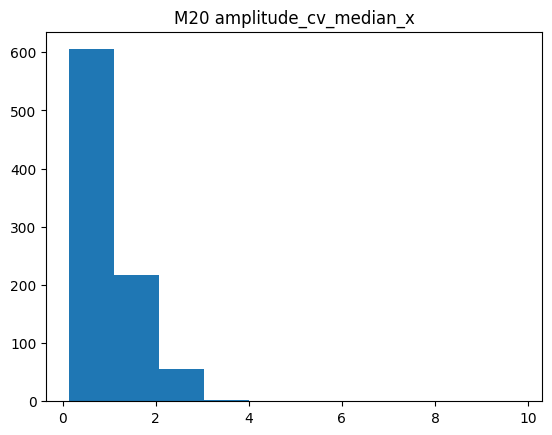

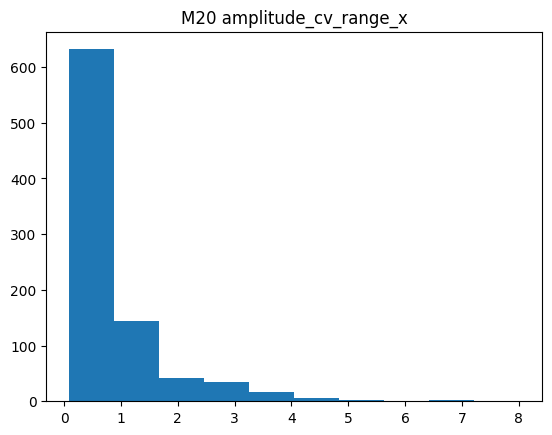

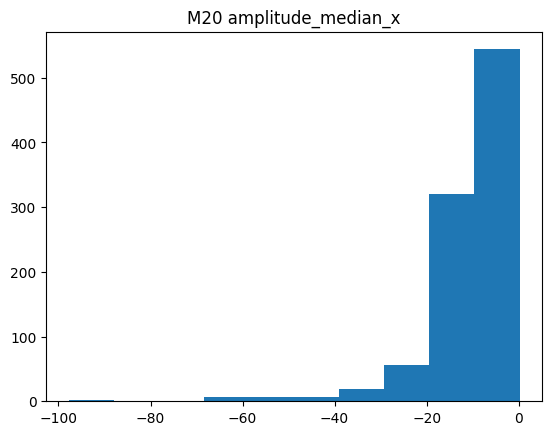

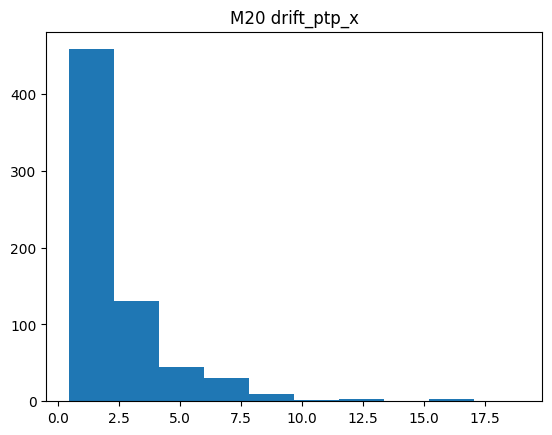

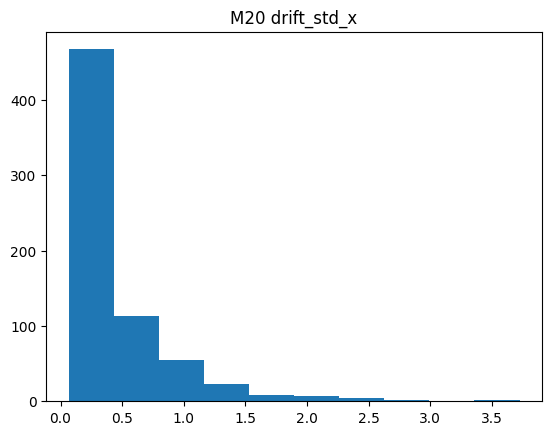

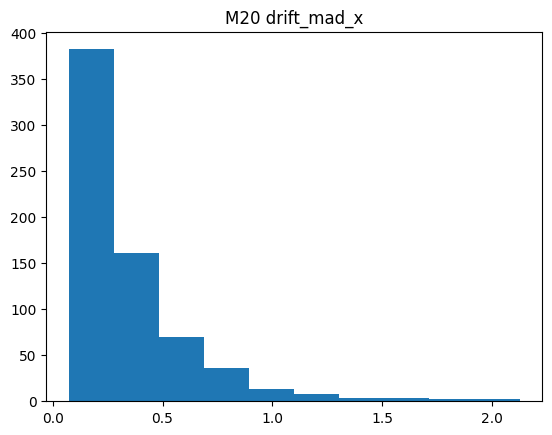

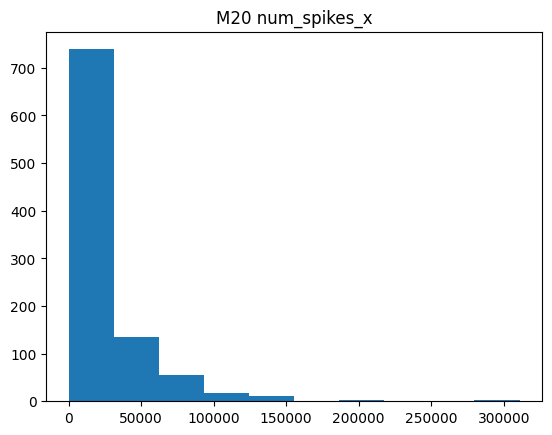

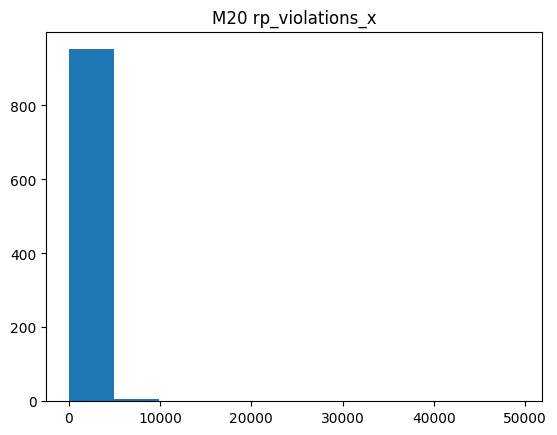

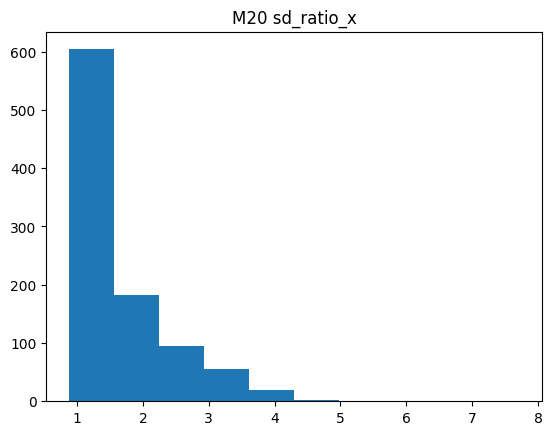

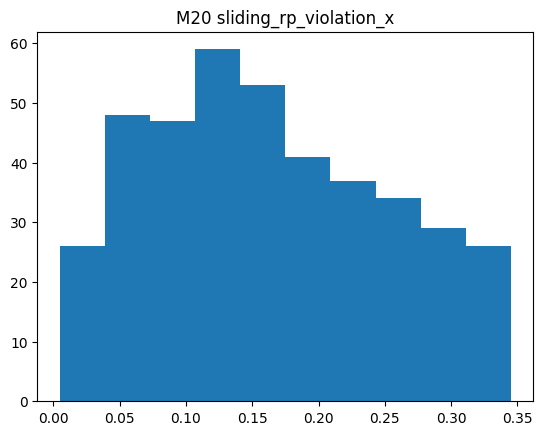

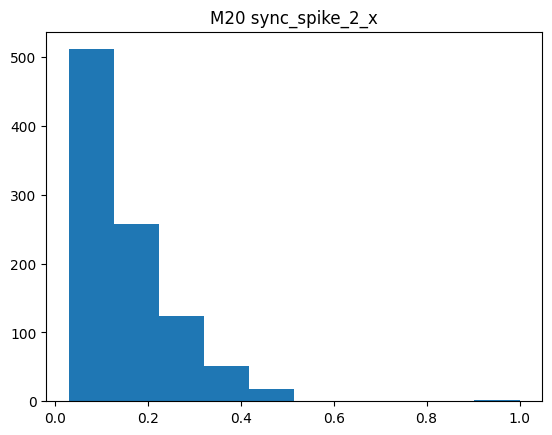

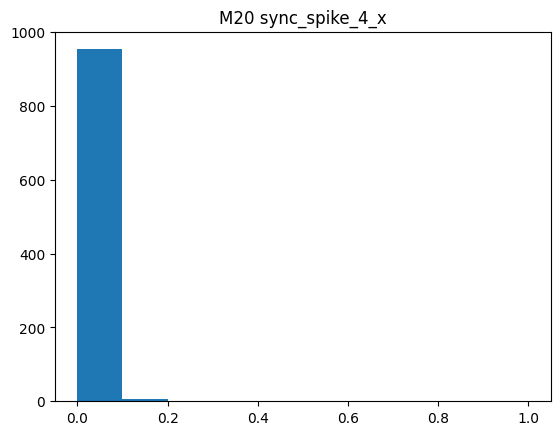

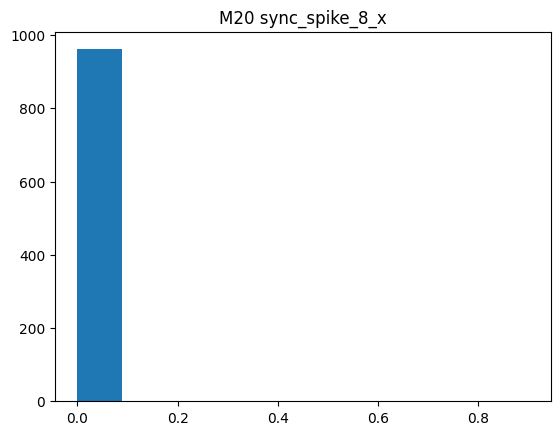

In [8]:
for col in ["isi_violations_ratio_x", "isi_violations_count_x", "presence_ratio_x", "rp_contamination_x", "snr_x", "mean_firing_rate_x",  "amplitude_cutoff_x", "amplitude_cv_median_x", 
            "amplitude_cv_range_x", "amplitude_median_x", "drift_ptp_x", "drift_std_x", "drift_mad_x", "num_spikes_x", "rp_violations_x", "sd_ratio_x", "sliding_rp_violation_x", "sync_spike_2_x", "sync_spike_4_x", "sync_spike_8_x"]:
    plt.hist(spike_data[col])
    plt.title(f"M20 {col}")
    plt.show()

##### using my curation step within get_data, I can elimate the big population of cells that contain a large refactory period violation

In [9]:
curated_spike_data = get_data(vr_session_base_names = ["M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"],
                      of_session_base_names = ["M20_D23_2024-05-25_14-10-43_OF1",
                      "M20_D24_2024-05-26_14-17-55_OF1", 
                      "M20_D25_2024-05-27_13-57-19_OF1",
                      "M20_D26_2024-05-28_14-31-11_OF1"], curate=True)

for M20 D23, there are 272
after curation, there are 104
for M20 D24, there are 235
after curation, there are 135
for M20 D25, there are 232
after curation, there are 54
for M20 D26, there are 224
after curation, there are 121


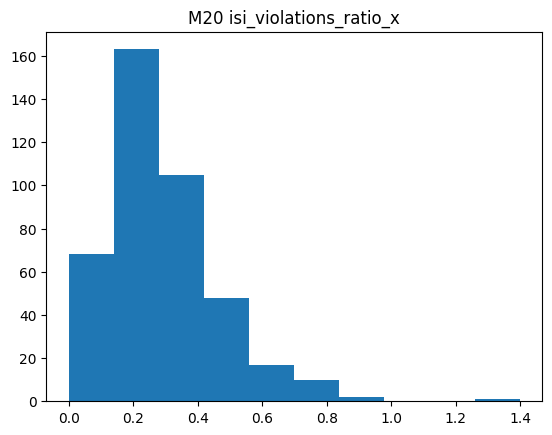

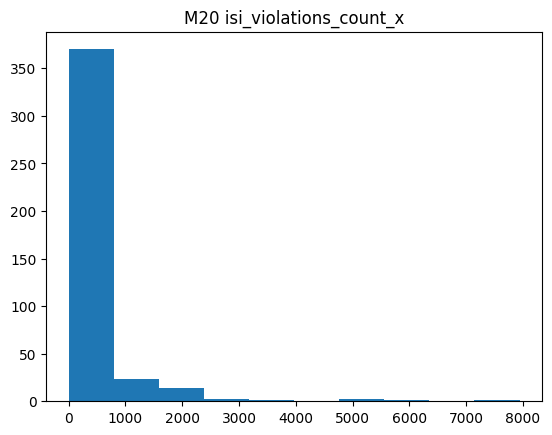

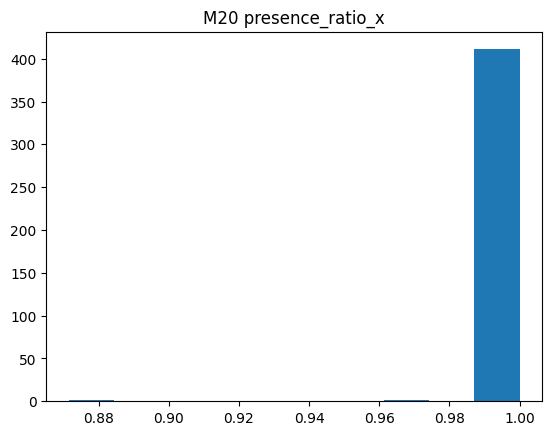

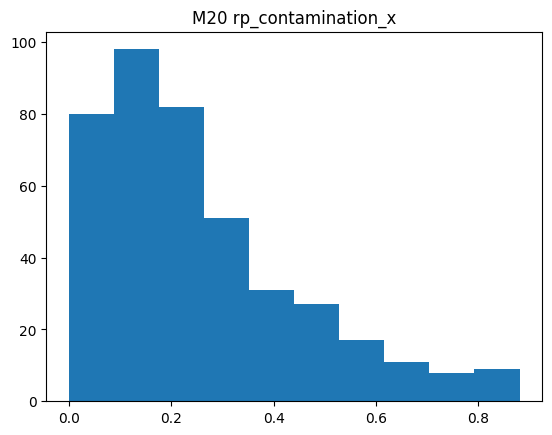

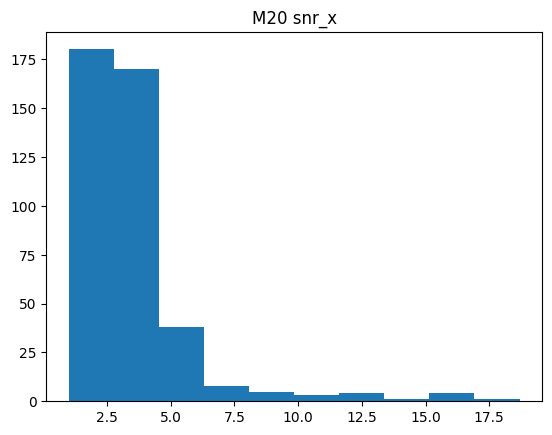

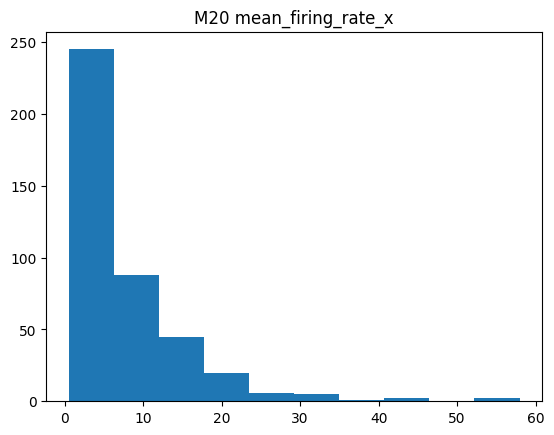

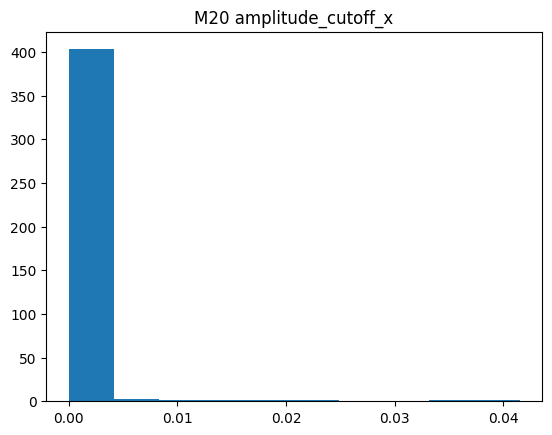

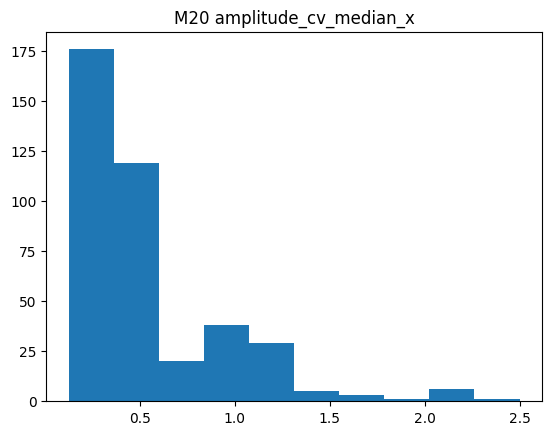

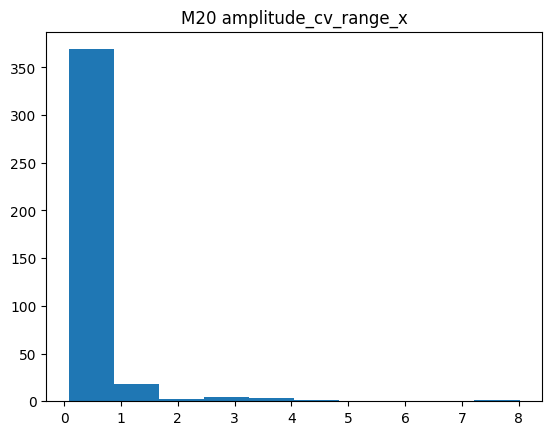

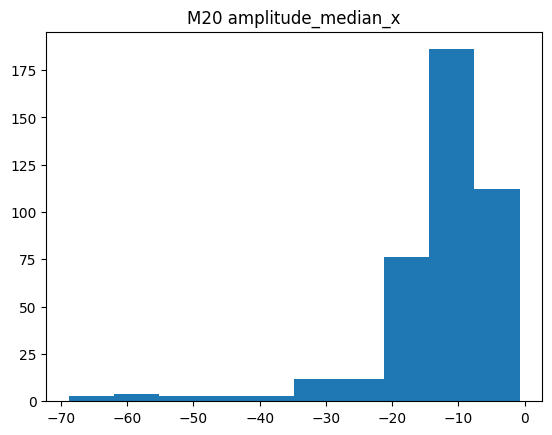

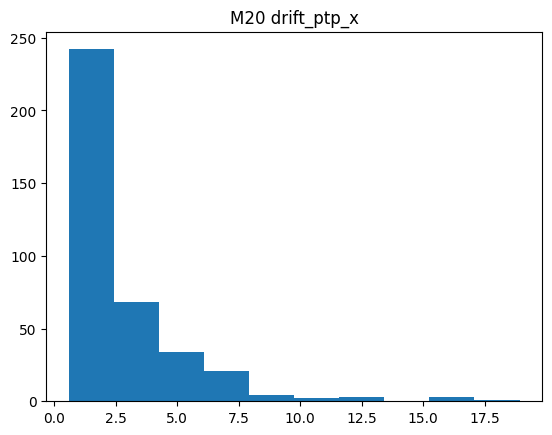

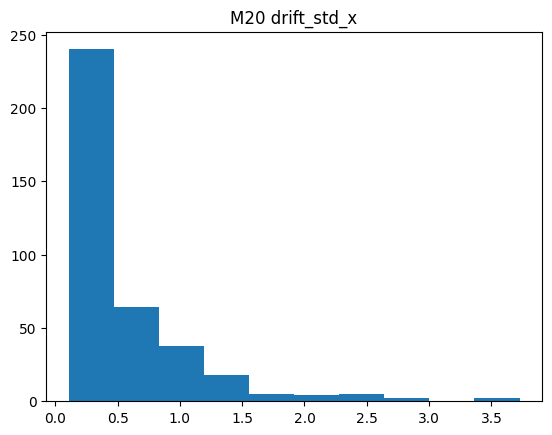

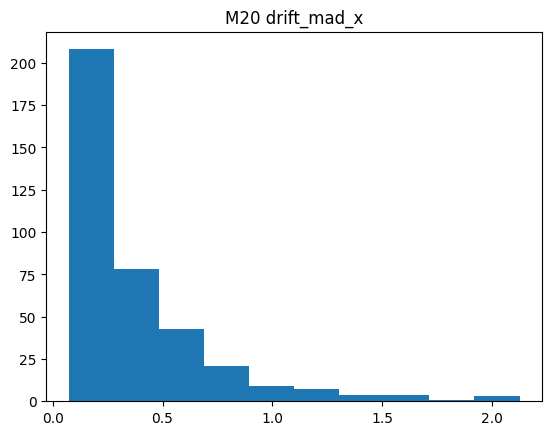

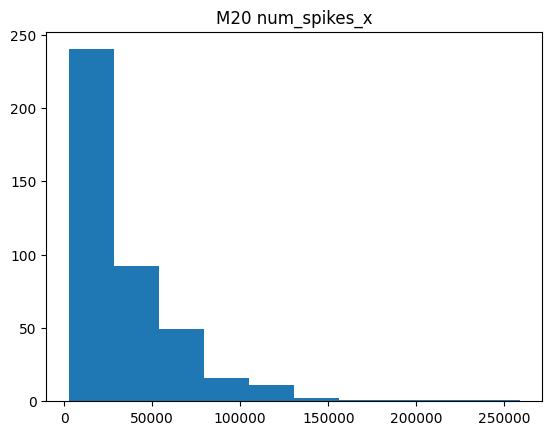

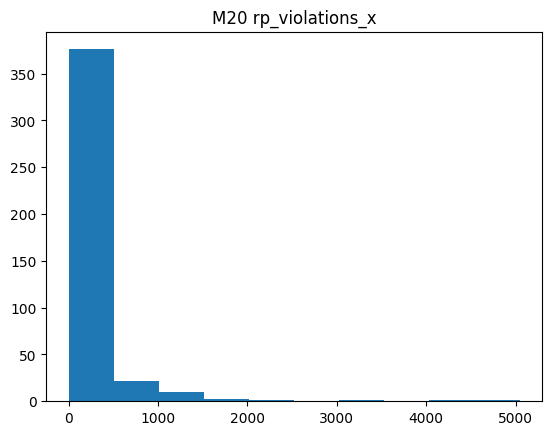

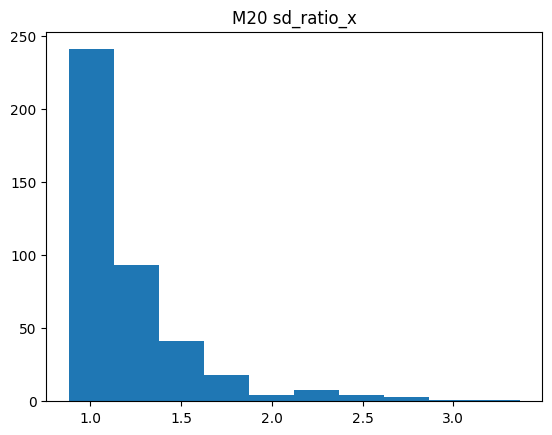

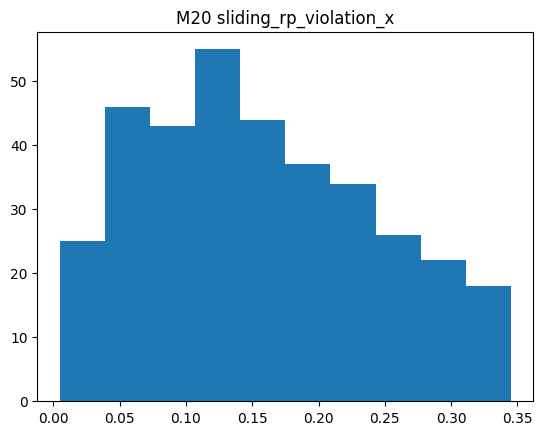

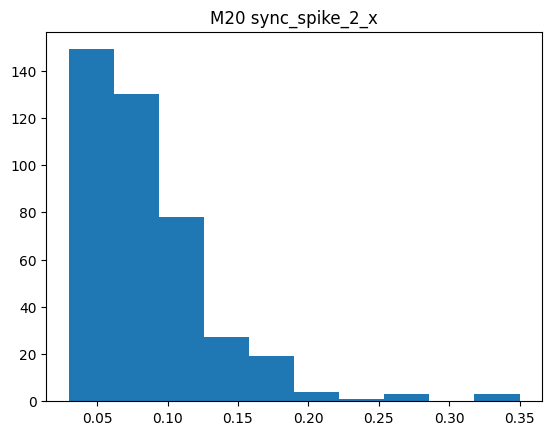

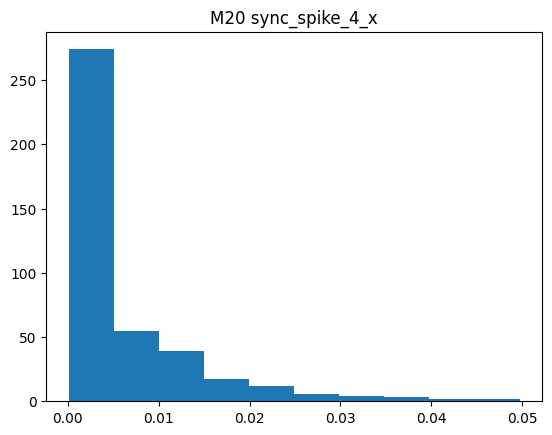

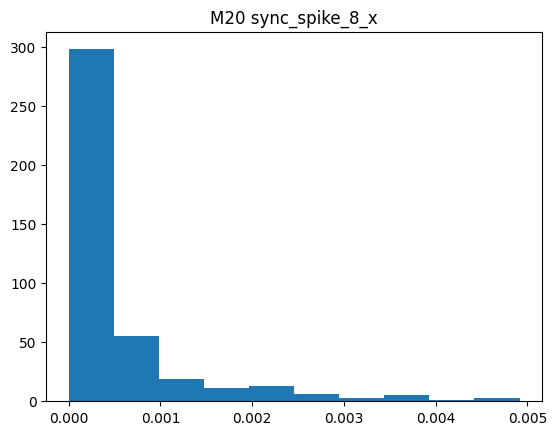

In [10]:
for col in ["isi_violations_ratio_x", "isi_violations_count_x", "presence_ratio_x", "rp_contamination_x", "snr_x", "mean_firing_rate_x",  "amplitude_cutoff_x", "amplitude_cv_median_x", 
            "amplitude_cv_range_x", "amplitude_median_x", "drift_ptp_x", "drift_std_x", "drift_mad_x", "num_spikes_x", "rp_violations_x", "sd_ratio_x", "sliding_rp_violation_x", "sync_spike_2_x", "sync_spike_4_x", "sync_spike_8_x"]:
    plt.hist(curated_spike_data[col])
    plt.title(f"M20 {col}")
    plt.show()

##### this however doesn't remove all clear units that don't originate from a neural source, for example see Z:\ActiveProjects\Harry\Cohort11_april2024\derivatives\M20\D25\ephys\report\units\226

In [18]:
print(np.sort(np.asarray(curated_spike_data[curated_spike_data["session_id_x"] == "M20_D25_2024-05-27_14-24-21_VR1"]["cluster_id"])))

[ 52  68  70  83  84  92  94  96  99 100 102 104 105 108 109 110 111 115
 116 117 118 119 120 123 126 127 128 130 134 153 154 156 158 159 161 163
 164 166 169 170 173 174 176 179 180 182 183 185 201 202 205 208 220 226]


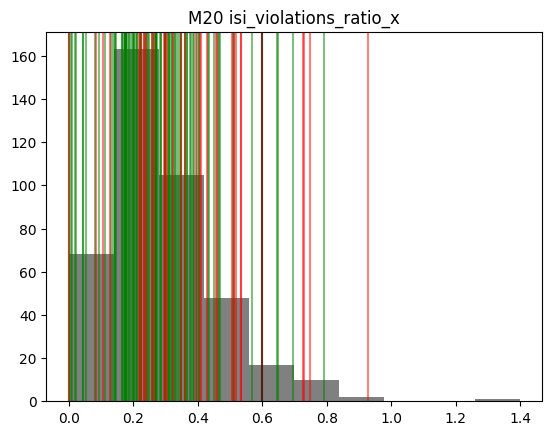

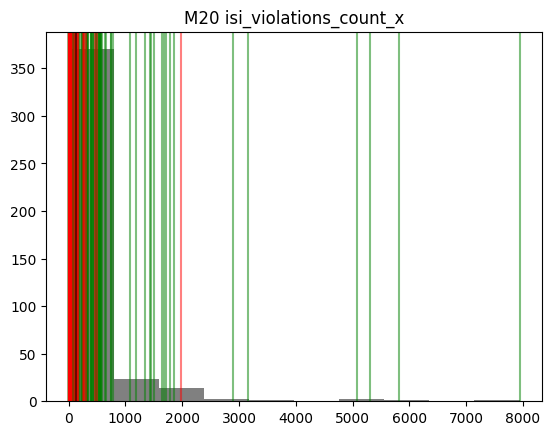

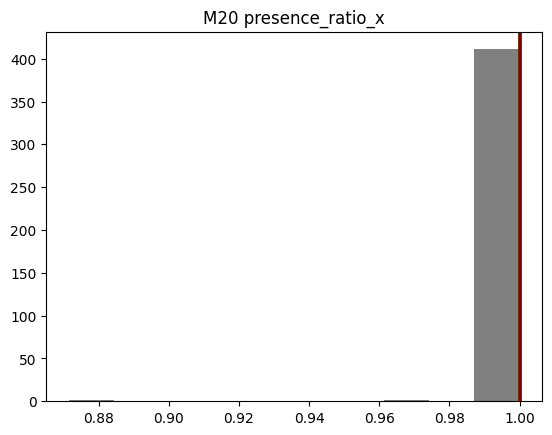

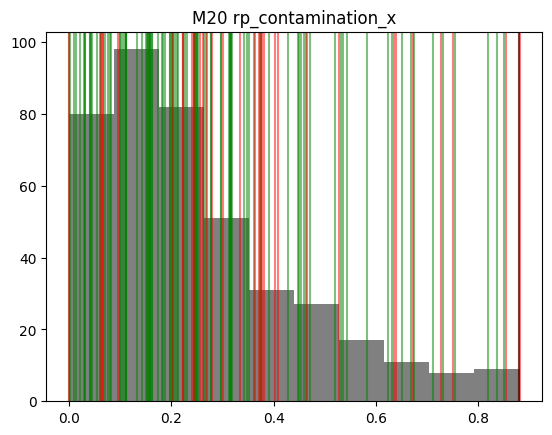

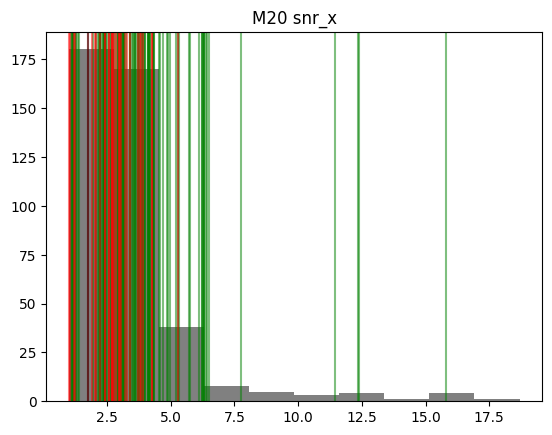

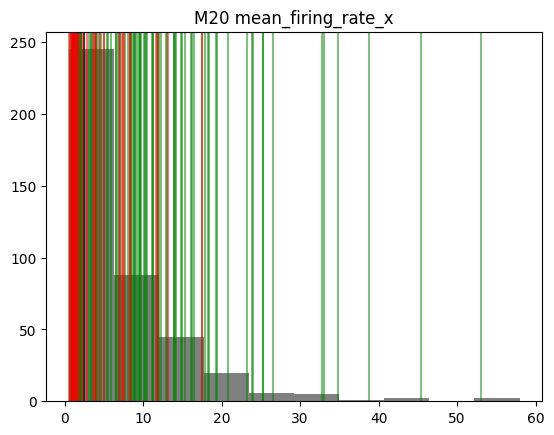

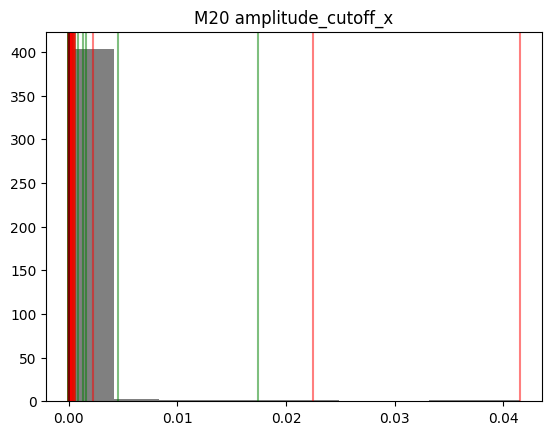

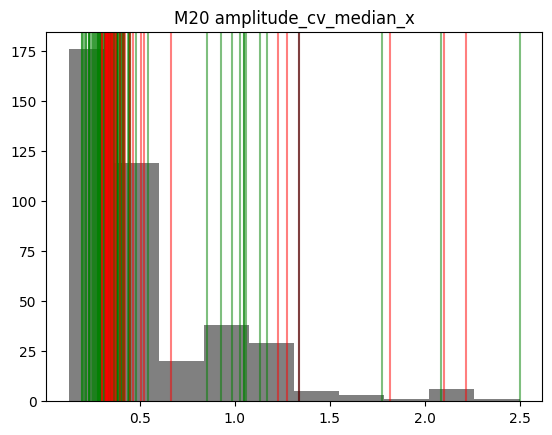

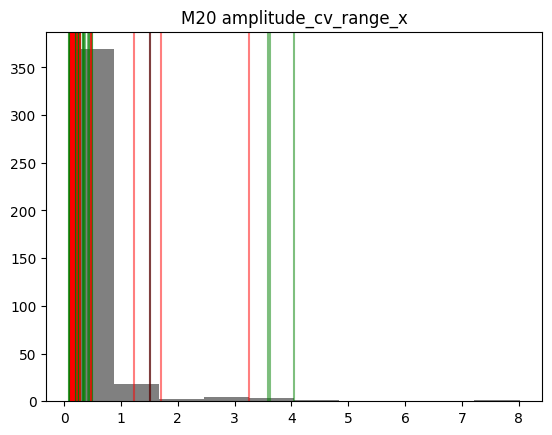

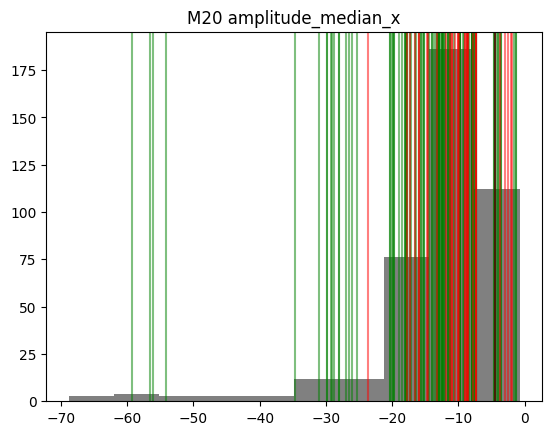

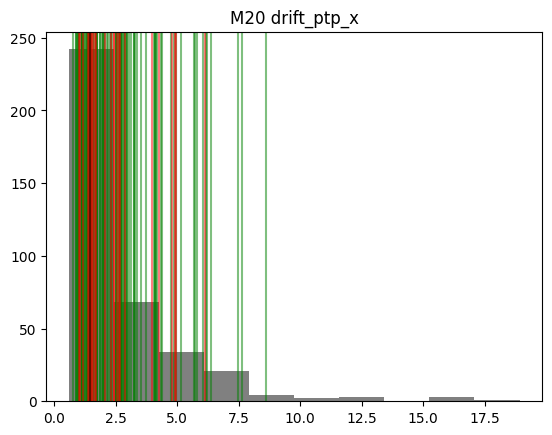

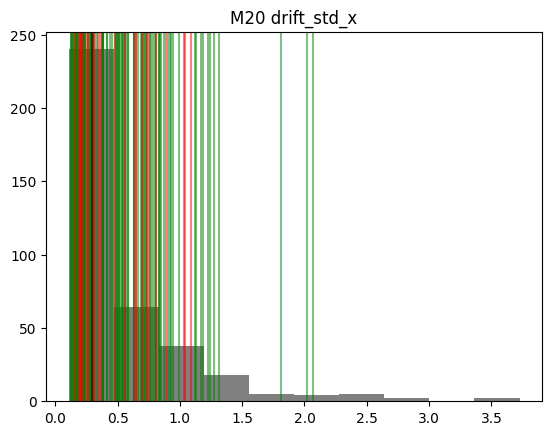

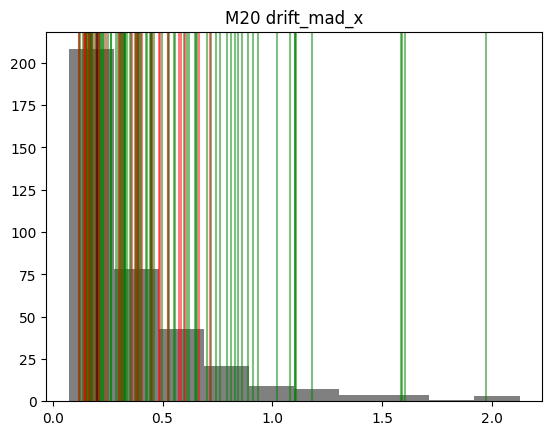

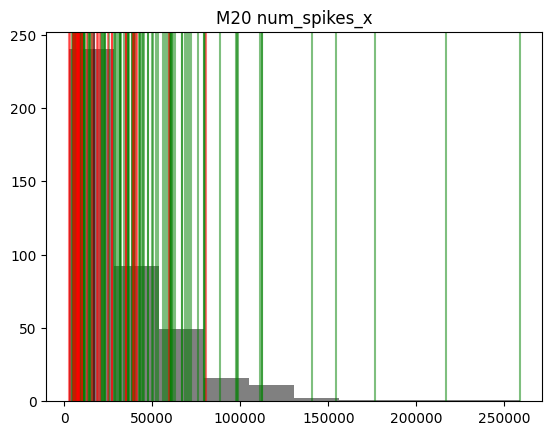

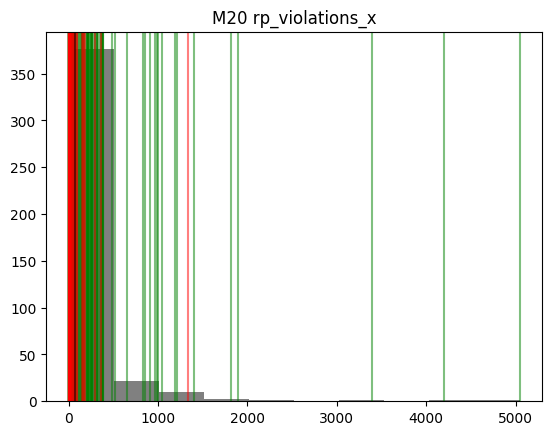

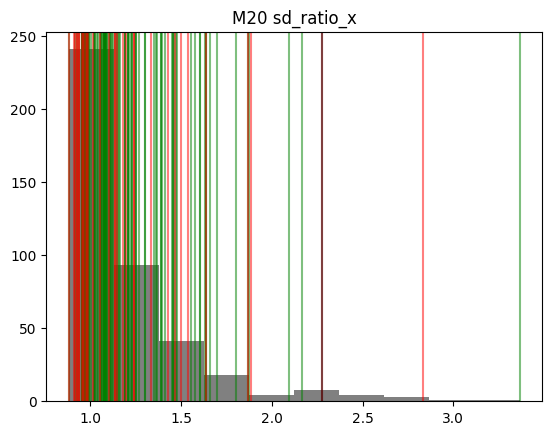

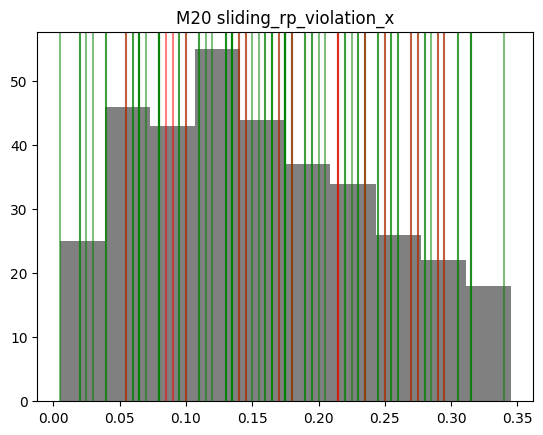

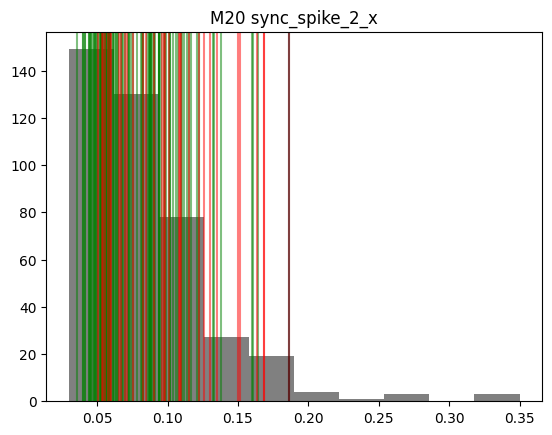

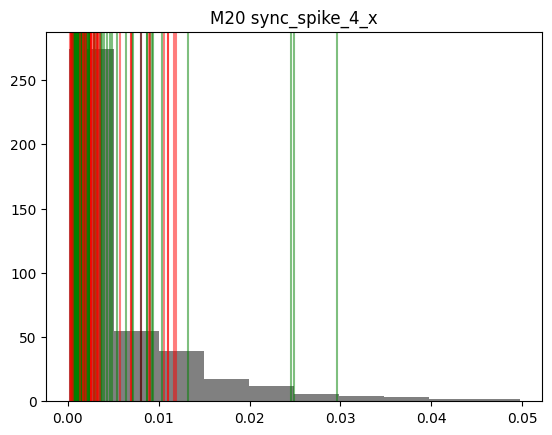

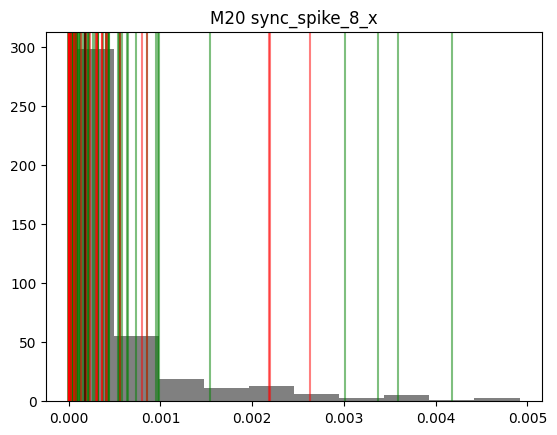

In [27]:
bad_curated_cluster_ids = np.array([109, 111, 134,153, 154, 156, 158, 174, 182, 183, 185, 201, 202, 205, 208, 220, 226])
good_curated_cluster_ids = np.array([52, 68, 70, 83, 84, 92, 94, 96, 99, 100, 102, 104, 105, 108, 110, 115, 116, 117, 118, 119, 120, 123, 126,127, 128, 130,159 , 161, 163, 164, 166, 169, 170, 173, 176, 179, 180])
example_bad_cluster_ids = np.array([226])

bad_curated_cells = curated_spike_data[np.isin(curated_spike_data["cluster_id"], bad_curated_cluster_ids)]
good_curated_cells = curated_spike_data[np.isin(curated_spike_data["cluster_id"], good_curated_cluster_ids)]
example_bad_cells = curated_spike_data[np.isin(curated_spike_data["cluster_id"], example_bad_cluster_ids)]

for col in ["isi_violations_ratio_x", "isi_violations_count_x", "presence_ratio_x", "rp_contamination_x", "snr_x", "mean_firing_rate_x",  "amplitude_cutoff_x", "amplitude_cv_median_x", 
            "amplitude_cv_range_x", "amplitude_median_x", "drift_ptp_x", "drift_std_x", "drift_mad_x", "num_spikes_x", "rp_violations_x", "sd_ratio_x", "sliding_rp_violation_x", "sync_spike_2_x", "sync_spike_4_x", "sync_spike_8_x"]:
    plt.hist(curated_spike_data[col], color="grey")
    for i in range((len(good_curated_cells))):
        plt.axvline(good_curated_cells[col].iloc[i], color="green", alpha=0.5)
    for i in range((len(bad_curated_cells))):
        plt.axvline(bad_curated_cells[col].iloc[i], color="red", alpha=0.5)
    for i in range(len(example_bad_cells)):
        plt.axvline(example_bad_cells[col].iloc[i], color="black", alpha=0.5)

    plt.title(f"M20 {col}")
    plt.show()

 ##### based on this we might want to adjust the curation metrics to include sd_ratio and decrease the tolerances for mean firing rate and rpcontamination

In [24]:
def get_data(vr_session_base_names, of_session_base_names, curate=True):
    project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
    
    master_data = pd.DataFrame()
    for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
        spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")
        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])

        position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
        processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
        position_data = pd.read_csv(position_path)
        processed_position_data = pd.read_pickle(processed_position_path)
        spike_data = calculate_spatial_information(spike_data, position_data, track_length=200)
        spike_data = spike_data.sort_values(by=["spatial_information_score_Isec"], ascending=False)

        print(f"for {mouse} {day}, there are {len(spike_data)}")
        if curate:
            spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                                    (spike_data["mean_firing_rate_x"] > 0.5) & 
                                    (spike_data["rp_contamination_x"] < 0.8) &
                                    (spike_data["sd_ratio_x"] > 1)]
            print(f"after curation, there are {len(spike_data)}")
        master_data = pd.concat([master_data, spike_data],ignore_index=True)
    return master_data

In [25]:
spike_data = get_data(vr_session_base_names = ["M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"],
                      of_session_base_names = ["M20_D23_2024-05-25_14-10-43_OF1",
                      "M20_D24_2024-05-26_14-17-55_OF1", 
                      "M20_D25_2024-05-27_13-57-19_OF1",
                      "M20_D26_2024-05-28_14-31-11_OF1"], curate=True)

for M20 D23, there are 272
after curation, there are 83
for M20 D24, there are 235
after curation, there are 111
for M20 D25, there are 232
after curation, there are 39
for M20 D26, there are 224
after curation, there are 88


In [28]:
print(np.sort(np.asarray(spike_data[spike_data["session_id_x"] == "M20_D25_2024-05-27_14-24-21_VR1"]["cluster_id"])))

[ 68  70  83  84  92  94  96  99 100 102 104 105 108 109 110 111 115 116
 117 118 119 120 126 127 128 130 134 154 156 158 159 161 163 164 166 169
 170 174 182]


In [ ]:
good_curated_cluster_ids = np.array([52, 68, 70, 83, 84, 92, 94, 96, 99, 100, 102, 104, 105, 108, 110, 115, 116, 117, 118, 119, 120, 123, 126,127, 128, 130,159 , 161, 163, 164, 166, 169, 170, 173, 176, 179, 180])


##### when repeated in a different mouse, similar results are seen

In [ ]:
spike_data = get_data(vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1", 
                                               "M21_D23_2024-05-25_16-54-12_VR1", 
                                               "M21_D25_2024-05-27_16-00-30_VR1", 
                                               "M21_D24_2024-05-26_16-35-19_VR1"],
                      of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1", 
                                               "M21_D23_2024-05-25_16-07-17_OF1", 
                                               "M21_D25_2024-05-27_15-35-57_OF1", 
                                               "M21_D24_2024-05-26_15-58-23_OF1"])

